# Vector-valued Kernel Ridge Regression

Using the same dataset of molecular geometries, we will predict the dipole moment $\mu$. 

In [1]:
from functools import partial
import jax.numpy as np
from jax import grad, jit, vmap

In [2]:
data = np.load('data/HOOH.DFT.PBE-TS.light.MD.500K.50k.R_E_F_D_Q.npz')
X = np.array(data['R'])
y = np.array(data['D'])
X.shape, y.shape

((50000, 4, 3), (50000, 3))

First, let's visualise some of our training data. We will encode it using the same Coulomb matrix-like descriptor as for the scalar valued case.

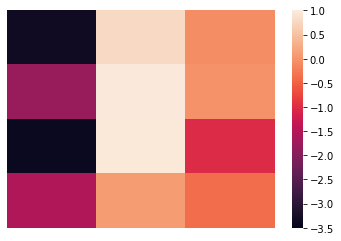

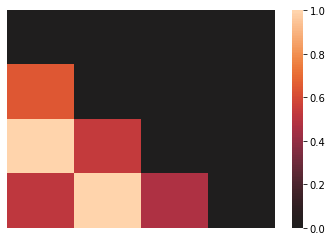

In [3]:
from utils import heatmap_animation, descriptor
%matplotlib inline

heatmap_animation(lambda i: X[i], name='coordinates', vmin=-3.5, vmax=1)
heatmap_animation(lambda i: descriptor(X[i]).reshape(4, 4), name='descriptors', center=0, vmax=1.0)

The following are the coordinates
![SegmentLocal](images/coordinates.gif "coordinates")
and descriptors
![SegmentLocal](images/descriptors.gif "descriptors")
for the first few training samples.

The dipole moment is a three-dimensional quantity. To learn this vector-valued function, we will need to adjust our KRR model.

### Model
our predictor is given by 

$$ \begin{equation} \vec{\mu} (\textbf{x}) = \sum_{l=1}^{M} \kappa_{rHess}^{(3\times 3)}(\textbf{x},\textbf{x}_l) \vec{\alpha}_l \end{equation} $$

where $\kappa_{rHess}^{(3\times 3)}(\textbf{x},\textbf{x}_l)$ is now not a scalar, but a 3x3 matrix given by

$$ \begin{equation} \kappa_{rHess}^{(3\times 3)}(\textbf{x},\textbf{x}_l) =\sum_{i,j=1}^{N} \text{Hess}_{ij}[\kappa(\textbf{x},\textbf{x}_l)] \end{equation} $$

with

$$
\begin{equation}
(\text{Hess}_{ij}[\kappa(\textbf{x},\textbf{x}_l)])_{km} = \frac{\partial^2 \kappa(\textbf{x},\textbf{x}_l)}{\partial (\textbf{x}_l)_{ik} \partial (\textbf{x}_l)_{jm}}
\end{equation}
$$

The Hessian of the similarity measure at $\textbf{x}$ is composed of the second derivatives of each pair of input elements, $(Hess)_{ikjm} = \frac{\partial^2 \kappa(\textbf{x},\textbf{x}_l)}{\partial (\textbf{x}_l)_{ik} \partial (\textbf{x}_l)_{jm}}$. In this case our data has two dimensions, so the Hessian has four. We will compute the derivatives using the Jax library.

In [4]:
from jax import jacfwd, jacrev
def hessian(f):
    return jacfwd(jacrev(f))

(4, 3, 4, 3)


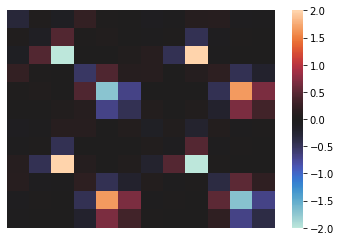

In [5]:
from utils import gaussian, fill_diagonal

_gaussian = partial(gaussian, X[0])
_hess = hessian(_gaussian)
print(_hess(X[1]).shape)

heatmap_animation(lambda i: _hess(X[i]).reshape(12, 12), name='hessians', center=0, vmax=2, vmin=-2)

The hessians of the similarity comparing to the first point in our dataset look as follows:
![SegmentLocal](images/hessians.gif "hessians")
We can also observe that $\text{Hess}_{ij}[\kappa(\textbf{x},\textbf{x}_l)] + \text{Hess}_{ji}[\kappa(\textbf{x},\textbf{x}_l)]$, is always symmetric, which will cause our 3x3 kernel to also be symmetric.

In [6]:
def hess_at(H, i, j):
    return H[i, :, j, :]

def symmetric(H):
    return np.allclose(H, H.T)

for k in range(3):
    H = _hess(X[k])
    for i in range(4):
        for j in range(4):
            print(symmetric(hess_at(H, i, j) + hess_at(H, j, i)), end=' ')
    print()

True True True True True True True True True True True True True True True True 
True True True True True True True True True True True True True True True True 
True True True True True True True True True True True True True True True True 


In [7]:
@jit
def kernel(x, x_, sigma=1):
    _gaussian = partial(gaussian, x, sigma=sigma)
    hess = hessian(_gaussian)
    return np.sum(hess(x_), axis=(0, 2))

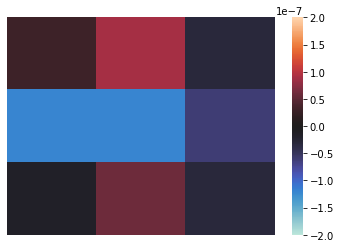

In [8]:
heatmap_animation(lambda i: kernel(X[0], X[i]), name='kernels', center=0, vmax=2*1e-7, vmin=-2*1e-7)

![SegmentLocal](images/kernels.gif "kernels")

In [9]:
@jit
def kernel_matrix(X, sigma=1):
    _kernel = partial(kernel, sigma=sigma)
    @vmap
    def _kernels(x):
        vec_kernel = vmap(partial(_kernel, x))
        return vec_kernel(X)
    K = _kernels(X)
    blocks = [list(x) for x in K]
    return np.block(blocks)

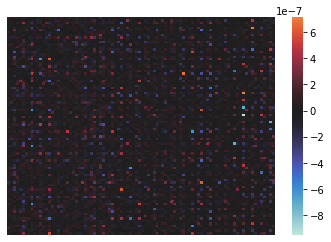

In [10]:
from utils import matrix_heatmap

K = kernel_matrix(X[:30])
matrix_heatmap(K, center=0)

Similar to single-valued KRR, we compute the parameters $\alpha$ which minimize error analytically. They are given by
$$
\begin{equation}\label{eq:KRRsol}
\alpha = [K_{\text{rHess}}^{(3\times 3)}(\textbf{X},\textbf{X}')-\lambda\textbf{I}]^{-1} \mu(\textbf{X})
\end{equation}
$$

Instead of inverting (expensive) we will solve the linear system of equations $[K_{\text{rHess}}^{(3\times 3)}(\textbf{X},\textbf{X}')-\lambda\textbf{I}] \alpha = \mu(\textbf{X})$.

In [11]:
from utils import KRR

class VectorValuedKRR(KRR):

    def fit(self, X, y):
        self.X = X
        samples = X.shape[0]
        K = kernel_matrix(X, sigma=self.sigma)
        y = y.reshape(samples * 3)
        K = fill_diagonal(K, K.diagonal() + self.lamb)
        alphas = np.linalg.solve(K, y)
        self.alphas = alphas.reshape(samples, 3)

    def predict(self, x):
        def contribution(i, x):
            return kernel(x, X[i], sigma=self.sigma) @ self.alphas[i]
        @vmap
        def predict(x):
            indices = np.arange(self.samples)
            _contribution = vmap(partial(contribution, x=x))
            contributions = _contribution(indices)
            mu = np.sum(contributions, axis=0)
            return mu
        results = predict(x)
        return np.array(results)

    def score(self, x, y):
        yhat = self.predict(x)
        return -np.mean(np.sum(np.abs(y - yhat), axis=1))

In [12]:
model = VectorValuedKRR()
model.fit(X[:50], y[:50])

In [13]:
print(model.predict(X[:2]))
print(y[:2])

[[ 0.06685638 -0.30673063 -0.5862386 ]
 [ 0.06523848 -0.30487794 -0.58123326]]
[[ 0.06685546 -0.3067279  -0.58624345]
 [ 0.06524433 -0.3048814  -0.58123165]]


In [14]:
model.score(X[50:60], y[50:60])

DeviceArray(-8.010721, dtype=float32)

## Conclusion

We have extended KRR to model a function with vector output. Some components of the learning contain symmetries, which can be used to check the implementation correctness. This model achieved a low training loss even with very few training examples. As a next step, we will learn forces, a function that maps to $\mathbb{R}^{4 \times 3}$.